# ME 572: Fall 2022 Computer Project
### TJ Wiegman
### 2022-11-21

In [1]:
# Read text file input
with open("RRR.txt") as file:
    RR = file.readlines()

for i in range(len(RR)):
    RR[i] = RR[i].rstrip() # rstrip removes newline characters

    # For documentation purposes: print contents of input file here
    print(RR[i])

.24,.015,2,3,RRR
4,1.5,13
4.2,-0.5,0


In [2]:
# Parse the input
## First line
timeTotal, timeStep, Sacc, Sdec, Title = RR[0].split(",")
timeTotal, timeStep = float(timeTotal), float(timeStep)
Sacc, Sdec = int(Sacc), int(Sdec)

## Second line
P0 = []
for coord in RR[1].split(","): P0.append(float(coord))

## Third line
PF = []
for coord in RR[2].split(","): PF.append(float(coord))

## For documentation purposes: print results
print(
    f"{Title}: Moving from {P0} to {PF} "
    f"over {timeTotal} seconds in {timeStep} second steps"
)

RRR: Moving from [4.0, 1.5, 13.0] to [4.2, -0.5, 0.0] over 0.24 seconds in 0.015 second steps


In [3]:
# Import inverse kinematics and jacobian based on input file
from importlib import import_module
robot = import_module(Title)
IK = robot.inverseKinematics
jac = robot.jacobian

# For documentation purposes: print out the code from that file here
fileTitle = Title + ".py"
print(fileTitle)
print("==========")
print(open(fileTitle).read())

RRR.py
from math import sqrt, atan2, acos, sin, cos

def inverseKinematics(px, py, pz):
    L1, L2, L3, D1 = 5, 5, 4, 4
    e = (px*px + py*py)
    th1 = atan2(py, px) - acos(D1 / sqrt(e))
    a = px - (D1 * cos(th1))
    b = py - (D1 * sin(th1))
    c = pz - L1
    d = (px * sin(th1)) - (py*cos(th1))
    th3 = acos((a*a + b*b + c*c - L2*L2 - L3*L3) / (2*L2*L3))
    num = (d * (L2 + L3*cos(th3))) - (c * L3 * sin(th3))
    den = (c * (L2 + L3*cos(th3))) + (d * L3 * sin(th3))
    th2 = atan2(num,den)
    return [th1, th2, th3]

from numpy import matrix
from numpy.linalg import inv

def jacobian(th1, th2, th3, vx, vy, vz, px, py, pz):
    L1, L2, L3, D1 = 5, 5, 4, 4
    th23 = th2 + th3

    j11 = -py
    j12 = (L3 * sin(th1) * cos(th23)) + (L2 * sin(th1) * cos(th2))
    j13 = L3 * sin(th1) * cos(th23)

    j21 = px
    j22 = (-L3 * cos(th1) * cos(th23)) - (L2 * cos(th1) * cos(th2))
    j23 = -L3 * cos(th1) * cos(th23)

    j31 = 0
    j32 = (-L3 * sin(th23)) - (L2 * sin(th2))
    j33 = -

In [4]:
# Calculate top velocities
assert (timeTotal / timeStep) % 1 == 0, "Total time must divide evenly by timestep!"
S = int(timeTotal / timeStep)
assert (Sacc + Sdec) <= S, "Cannot accelerate + decelerate longer than total time!"
Smod = S - 0.5*Sacc - 0.5*Sdec

vMax = [0, 0, 0]
for i in range(3):
    vMax[i] = (PF[i] - P0[i]) / (Smod * timeStep)

print(vMax)

[0.9876543209876553, -9.876543209876544, -64.19753086419753]


In [5]:
# Calculate velocity curves
velocity = [[0], [0], [0]]
for i in range(3):
    # Acceleration
    for j in range(Sacc):
        velocity[i].append(vMax[i] * ((j+1) / Sacc))
    
    # Steady state
    for j in range(S - (Sacc + Sdec)):
        velocity[i].append(vMax[i])
    
    # Deceleration
    for j in range(Sdec):
        velocity[i].append(vMax[i] * ((Sdec - j - 1)/Sdec))

In [6]:
# Calculate position curves
position = [[P0[0]], [P0[1]], [P0[2]]]
for i in range(3):
    for t in range(1,S):
        position[i].append(position[i][-1] + velocity[i][t]*timeStep)
    position[i].append(PF[i])

Text(0.5, 0, 'Time (seconds)')

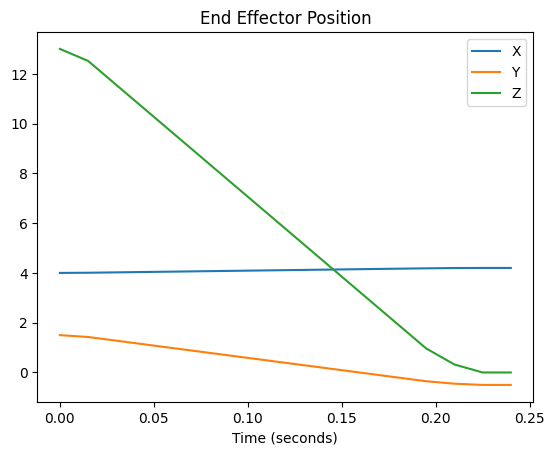

In [7]:
# Make position plot
import matplotlib.pyplot as plt

time = [0]
for _ in range(S): time.append(time[-1]+timeStep)

for i in range(3): plt.plot(time, position[i])

plt.title("End Effector Position")
plt.legend(["X", "Y", "Z"])
plt.xlabel("Time (seconds)")

In [8]:
# Calculate joint angles
from math import degrees

th1, th2, th3 = IK(P0[0], P0[1], P0[2])
thetas = [[degrees(th1)], [degrees(th2)], [degrees(th3)]]

for i in range(S):
    th1, th2, th3 = IK(position[0][i+1], position[1][i+1], position[2][i+1])
    thetas[0].append(degrees(th1))
    thetas[1].append(degrees(th2))
    thetas[2].append(degrees(th3))

Text(0.5, 0, 'Time (seconds)')

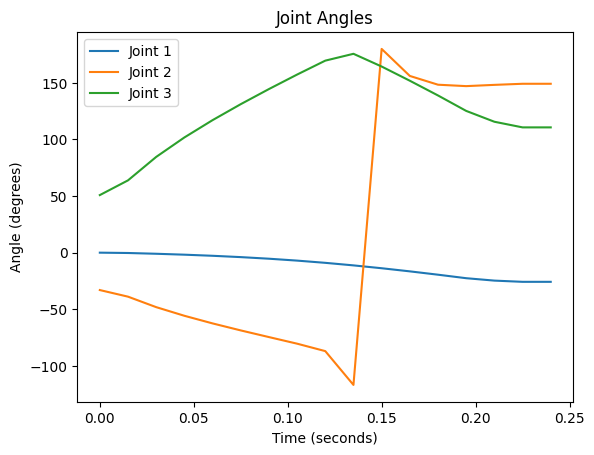

In [9]:
# Make angle plots
for i in range(3): plt.plot(time, thetas[i])

plt.title("Joint Angles")
plt.legend(["Joint 1", "Joint 2", "Joint 3"])
plt.ylabel("Angle (degrees)")
plt.xlabel("Time (seconds)")

In [10]:
# Get joint rates
from math import radians
dotThetas = [[0], [0], [0]]
for i in range(S):
    dth1, dth2, dth3 = jac(
        radians(thetas[0][i+1]),
        radians(thetas[1][i+1]),
        radians(thetas[2][i+1]),
        velocity[0][i+1],
        velocity[1][i+1],
        velocity[2][i+1],
        position[0][i+1],
        position[1][i+1],
        position[2][i+1]
    )
    dotThetas[0].append(dth1)
    dotThetas[1].append(dth2)
    dotThetas[2].append(dth3)

Text(0.5, 0, 'Time (seconds)')

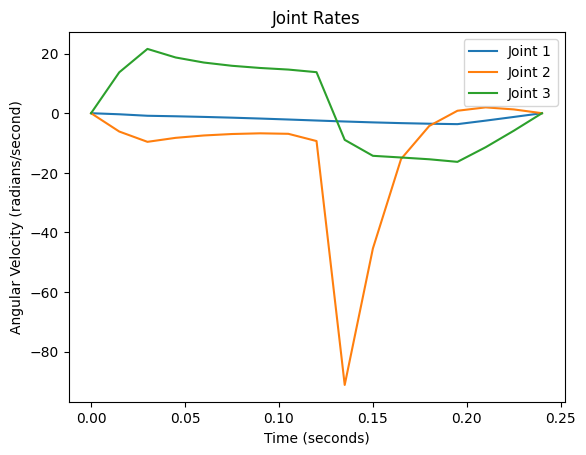

In [11]:
# Plot joint rates
for i in range(3): plt.plot(time, dotThetas[i])

plt.title("Joint Rates")
plt.legend(["Joint 1", "Joint 2", "Joint 3"])
plt.ylabel("Angular Velocity (radians/second)")
plt.xlabel("Time (seconds)")

In [12]:
# Generate output report
report = [",".join([
    "Time",
    "Px",
    "Py",
    "Pz",
    "Theta 1",
    "Theta 2",
    "Theta 3",
    "Theta-dot 1",
    "Theta-dot 2",
    "Theta-dot 3"
])]

for i in range(len(time)):
    report.append(",".join([
        str(time[i]),            # Time
        str(position[0][i]),     # Px
        str(position[1][i]),     # Py
        str(position[2][i]),     # Pz
        str(thetas[0][i]),       # Theta 1
        str(thetas[1][i]),       # Theta 2
        str(thetas[2][i]),       # Theta 3
        str(dotThetas[0][i]),    # Theta-dot 1
        str(dotThetas[1][i]),    # Theta-dot 2
        str(dotThetas[2][i])     # Theta-dot 3
    ]))

In [13]:
# Save the report to a file
outputTitle = Title + ".csv"
with open(outputTitle, mode = "w") as file:
    file.write("\n".join(report))

# For documentation purposes: print the file here
with open(outputTitle, mode = "r") as file:
    print(file.read())

Time,Px,Py,Pz,Theta 1,Theta 2,Theta 3,Theta-dot 1,Theta-dot 2,Theta-dot 3
0,4.0,1.5,13.0,6.3611093629270335e-15,-33.02444851992605,50.85759440358768,0,0,0
0.015,4.007407407407407,1.4259259259259258,12.518518518518519,-0.2955001720920082,-38.86111177596609,63.86309632502407,-0.3589785649011977,-6.151358153814702,13.723165919586569
0.03,4.022222222222222,1.2777777777777777,11.555555555555555,-0.9706160512484265,-48.11476133866482,84.56839815428263,-0.8581351036043056,-9.606824456889303,21.571756308221076
0.045,4.037037037037037,1.1296296296296295,10.592592592592592,-1.78002829328194,-55.74122692538416,101.75513083838469,-1.0314727131170045,-8.26779961724698,18.7022516951567
0.06,4.051851851851852,0.9814814814814814,9.629629629629628,-2.7546834687141133,-62.477559347092445,117.04196683949884,-1.2434723172890523,-7.471730057755569,17.004127741818916
0.075,4.066666666666667,0.8333333333333333,8.666666666666664,-3.929447539745731,-68.67114775046886,131.15386020018374,-1.497360653580192,-6.98